In [1]:
import sys
import os
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import numpy as np
import pandas as pd
from GENIE3.GENIE3 import *
from sklearn.metrics import roc_auc_score
from utils import gt_benchmark, precision_at_k
import SERGIO.sergio as sergio
import re
import os
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
import hashlib

import tensorflow as tf
print("gpu available: ", tf.config.list_physical_devices('GPU'))
# !pwd

2024-09-20 14:22:40.062363: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-20 14:22:41.280987: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-20 14:22:43.556025: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-20 14:22:43.557272: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-20 14:23:01.797909: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

gpu available:  []


2024-09-20 14:23:25.699566: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
def parse_dataset_name(folder_name):
    pattern1 = r'De-noised_(\d+)G_(\d+)T_(\d+)cPerT_dynamics_(\d+)_DS(\d+)'
    pattern2 = r'De-noised_(\d+)G_(\d+)T_(\d+)cPerT_(\d+)_DS(\d+)'
    match_p1 = re.match(pattern1, folder_name)
    match_p2 = re.match(pattern2, folder_name)
    if match_p1:
        return {
            'number_genes': int(match_p1.group(1)),
            'number_bins': int(match_p1.group(2)),
            'number_sc': int(match_p1.group(3)),
            'dynamics': int(match_p1.group(4)),
            'dataset_id': int(match_p1.group(5)),
            "pattern": "De-noised_{number_genes}G_{number_bins}T_{number_sc}cPerT_dynamics_{dynamics}_DS{dataset_id}"
        }
    if match_p2:
        return {
            'number_genes': int(match_p2.group(1)),
            'number_bins': int(match_p2.group(2)),
            'number_sc': int(match_p2.group(3)),
            'dynamics': int(match_p2.group(4)),
            'dataset_id': int(match_p2.group(5)),
            "pattern": "De-noised_{number_genes}G_{number_bins}T_{number_sc}cPerT_{dynamics}_DS{dataset_id}"
        }
    return

def get_datasets():
    datasets = []
    for folder_name in os.listdir('./data_sets'):
        dataset_info = parse_dataset_name(folder_name)
        if dataset_info:
            datasets.append(dataset_info)
    return sorted(datasets, key=lambda x: x['dataset_id'])

def fstr(template):
    return eval(f'f"""{template}"""')

def experiment(data_info):
    sim = sergio.sergio(
        number_genes=data_info["number_genes"],
        number_bins=data_info["number_bins"], 
        number_sc=data_info["number_sc"],
        noise_params=1,
        decays=0.8, 
        sampling_state=15,
        noise_type='dpd'
    )
    # sim.build_graph(input_file_taregts ='data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Interaction_cID_6.txt',\
    #                 input_file_regs='data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Regs_cID_6.txt', shared_coop_state=2)
    number_genes = data_info["number_genes"]
    number_bins = data_info["number_bins"]
    number_sc = data_info["number_sc"]
    dynamics = data_info["dynamics"]
    dataset_id = data_info["dataset_id"]
    pattern = data_info["pattern"]
    folder_name = pattern.format(number_genes=number_genes, number_bins=number_bins, 
                                 number_sc=number_sc, dynamics=dynamics, dataset_id=dataset_id)
    input_file_targets = f'./data_sets/{folder_name}/Interaction_cID_{data_info["dynamics"]}.txt'
    input_file_regs = f'./data_sets/{folder_name}/Regs_cID_{data_info["dynamics"]}.txt'
    
    sim.build_graph(
        input_file_taregts=input_file_targets,
        input_file_regs=input_file_regs,
        shared_coop_state=2
    )
    sim.simulate()
    expr = sim.getExpressions()
    expr_clean = np.concatenate(expr, axis=1)
    return sim, expr, expr_clean

def save_data(dataset_id, expr_clean, expr, sim, iter=0):
    print(f"DS{dataset_id}: {expr_clean.shape}")
    os.makedirs('./imputation_data/DS{dataset_id}', exist_ok=True)
    np.save(f'./imputation_data/DS{dataset_id}/DS6_clean_iter_{iter}', expr_clean)
    np.save(f'./imputation_data/DS{dataset_id}/DS6_expr_iter_{iter}', expr)
    cmat_clean = sim.convert_to_UMIcounts(expr)
    cmat_clean = np.concatenate(cmat_clean, axis=1)
    np.save(f'./imputation_data/DS{dataset_id}/DS6_clean_counts_iter_{iter}', cmat_clean)

def sparse_ratio(data):
    # ndarray
    return 1 - np.count_nonzero(data) / data.size

def get_sparsity_of_binary_ind(sim, expr, expr_clean, percentile=45, dataset_id=6, iter=0):
    """
    Add outlier genes
    """
    expr_O = sim.outlier_effect(expr, outlier_prob = 0.01, mean = 5, scale = 1)

    """
    Add Library Size Effect
    """
    libFactor, expr_O_L = sim.lib_size_effect(expr_O, mean = 4.5, scale = 0.7)

    """
    Add Dropouts
    """
    binary_ind = sim.dropout_indicator(expr_O_L, shape = 8, percentile = percentile)
    expr_O_L_D = np.multiply(binary_ind, expr_O_L)

    """
    Convert to UMI count
    """
    count_matrix = sim.convert_to_UMIcounts(expr_O_L_D)

    """
    Make a 2d gene expression matrix
    """
    count_matrix = np.concatenate(count_matrix, axis = 1)
    # count_matrix = np.concatenate(expr_O_L_D, axis = 1)

    if iter == 1:
        row_sums = np.sum(count_matrix, axis=1, keepdims=True)
        count_matrix = count_matrix / row_sums
    elif iter == 2:
        count_matrix = np.log1p(count_matrix)
    elif iter == 3:
        means = np.mean(count_matrix, axis=0)
        stddevs = np.std(count_matrix, axis=0)
        count_matrix = (count_matrix - means) / stddevs
    elif iter == 4:
        from sklearn.preprocessing import quantile_transform
        count_matrix = quantile_transform(count_matrix, axis=0, copy=True)
    elif iter == 5:
        total_counts = np.sum(count_matrix, axis=1, keepdims=True)
        count_matrix = (count_matrix / total_counts) * 1e6
    
    os.makedirs(os.path.dirname(f'./imputation_data/DS{dataset_id}'), exist_ok=True)
    np.save(f'./imputation_data/DS{dataset_id}/DS6_45_iter_{iter}', count_matrix)
    print(count_matrix.shape)
    return sparse_ratio(binary_ind), expr_O, libFactor, expr_O_L, binary_ind, count_matrix

def compute_checksum(data):
    if isinstance(data, np.ndarray):
        return hashlib.md5(data.tobytes()).hexdigest()
    elif isinstance(data, list):
        return hashlib.md5(str(data).encode()).hexdigest()
    else:
        return hashlib.md5(str(data).encode()).hexdigest()

def compute_stats(data):
    if isinstance(data, np.ndarray):
        return {
            'checksum': compute_checksum(data),
            'mean': np.mean(data),
            'std': np.std(data)
        }
    elif isinstance(data, list):
        return {
            'checksum': compute_checksum(data),
            'mean': np.mean(data),
            'std': np.std(data)
        }
    else:
        return {
            'checksum': compute_checksum(data),
            'value': data
        }

def compare_attempts(attempts):
    comparison = {}
    for key in attempts[0].keys():
        values = [attempt[key]['checksum'] for attempt in attempts]
        comparison[key] = len(set(values)) > 1
    return comparison

def run_experiment_for_dataset(sim, expr, expr_clean, dataset_id):
    percentiles = range(1, 101, 10)
    sparsity_ratios = []

    for percentile in tqdm(percentiles):
        # radio_attemps = []
        # attempt_results = []
        for _ in range(2):
            ratio, expr_O, libFactor, expr_O_L, binary_ind, count_matrix = get_sparsity_of_binary_ind(sim, expr, expr_clean, percentile=percentile, dataset_id=dataset_id)
            # radio_attemps.append(ratio)
            # attempt_data = {
            #     'expr_O': compute_stats(expr_O),
            #     'libFactor': compute_stats(libFactor),
            #     'expr_O_L': compute_stats(expr_O_L),
            #     'binary_ind': compute_stats(binary_ind),
            #     'count_matrix': compute_stats(count_matrix)
            # }
            # attempt_results.append(attempt_data)

        # ratio = np.mean(radio_attemps)
        # sparsity_ratios.append(ratio)
        # comparison = compare_attempts(attempt_results)
        # Save comparison results
        # comparison_path = f"./results/DS{dataset_id}/percentile_{percentile}_comparison.txt"
        # os.makedirs(os.path.dirname(comparison_path), exist_ok=True)
        # with open(comparison_path, 'w') as f:
        #     f.write(f"Comparison results for percentile {percentile}:\n")
        #     for key, is_different in comparison.items():
        #         f.write(f"{key} is different across attempts: {is_different}\n")
        #     f.write("\n")
        #     for i, attempt_data in enumerate(attempt_results):
        #         f.write(f"Attempt {i+1} data:\n")
        #         for key, value in attempt_data.items():
        #             f.write(f"{key}:\n")
        #             for stat, stat_value in value.items():
        #                 f.write(f"  {stat}: {stat_value}\n")
        #         f.write("\n")

    plt.figure(figsize=(10, 6))
    plt.plot(percentiles, sparsity_ratios, marker='o')
    plt.title(f'{dataset_id}: sparsity ratio vs percentile')
    plt.ylabel('Sparsity ratio')
    plt.xlabel('Percentile')
    plt.grid(True)
    plt.savefig(f"./experiments/sparsity/sparsity_ratio_plot_{dataset_id}.png")
    print(f"Dataset: {dataset['dataset_id']}")
    print(f"Minimum sparsity ratio: {min(sparsity_ratios):.4f} at percentile {percentiles[sparsity_ratios.index(min(sparsity_ratios))]}")
    print(f"Maximum sparsity ratio: {max(sparsity_ratios):.4f} at percentile {percentiles[sparsity_ratios.index(max(sparsity_ratios))]}")
    print(f"Average sparsity ratio: {sum(sparsity_ratios) / len(sparsity_ratios):.4f}")
    print()

Experiment on clean data, generate clean data multiple times, and see if metrics on clean data have changed significantly.

  0%|                                                                                                          | 0/1 [00:00<?, ?it/s]

Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 12 threads
Elapsed time: 112.34 seconds



100%|████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 340970.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:00<00:00, 1274504.52it/s]

finished experiment iter 0
DS1: (100, 2700)
saved data
(100, 2700)
Tree method: RF
K: sqrt
Number of trees: 100


running jobs on 12 threads


Elapsed time: 32.04 seconds



100%|████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 334250.45it/s]

Running iterations: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [04:25<00:00, 265.07s/it]

Mean ROC AUC on Clean: 0.6905 ± 0.0000
Mean ROC AUC on Noisy: 0.4930 ± 0.0000


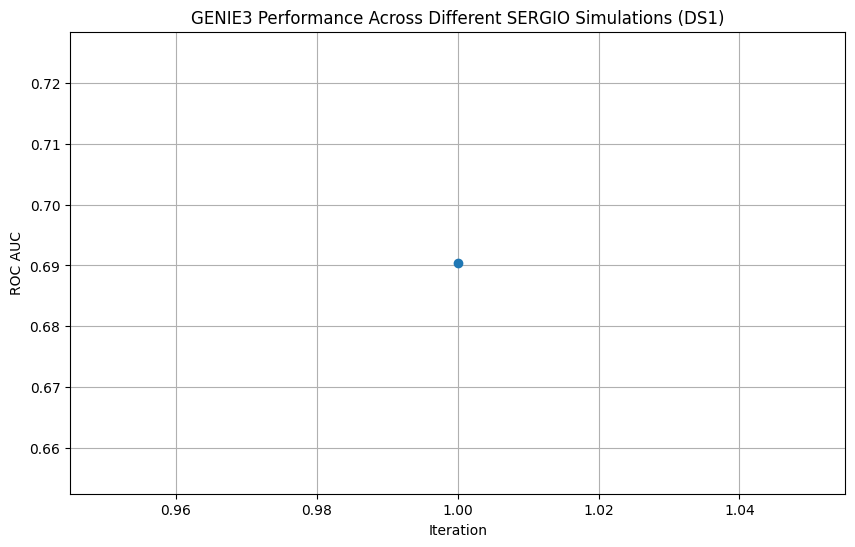

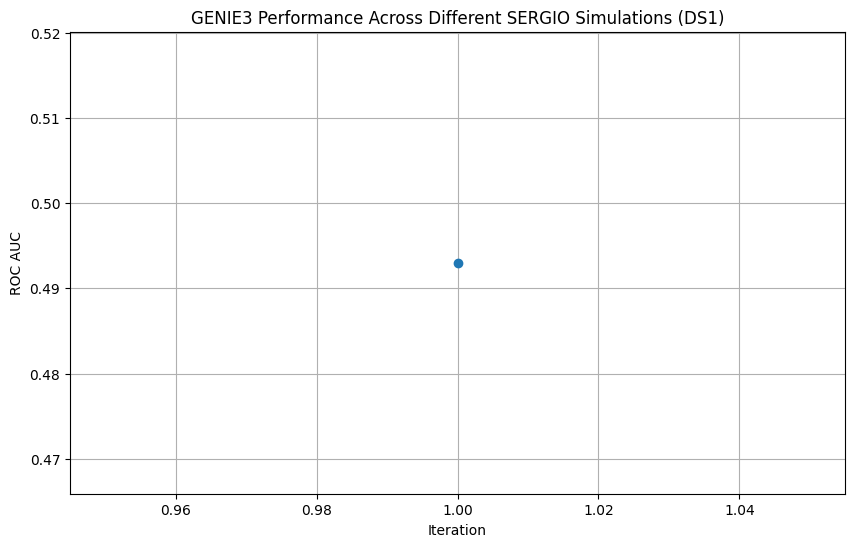

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [04:25<00:00, 265.55s/it]

Iteration 0: ROC AUC = 0.6905
Iteration 0: ROC AUC = 0.4930
Clean - Results for dataset 1: [{'iteration': 0, 'roc_auc': 0.6904512388618609, 'precision_k': [0.015242286430911805, 0.011928922042138829, 0.018102329587429224, 0.017883154664735775, 0.016030401498968647, 0.014974253832804256, 0.014984086886678625, 0.015023617012758955, 0.014210689003310066, 0.014062385428764531, 0.013416911421191873, 0.01369012493640928, 0.013264168820110594, 0.013419866704004302, 0.013020572901281637, 0.01321851567853749, 0.013036488356778812, 0.012926592951910816, 0.012713700223385261, 0.013006963722042936, 0.012868053301273871, 0.012721807105329481, 0.012646115796057667, 0.012501637218705133, 0.01251808398916816, 0.012654740884130052, 0.012540562329560563, 0.01239245654287976, 0.012250216251862027, 0.012231724856802951, 0.012080556025877083, 0.012100188656604382, 0.012009916844262369, 0.012044707872910485, 0.012104578900988991, 0.012005889174269334, 0.011846399240017687, 0.01170374671118668, 0.01171389437

In [5]:
datasets = get_datasets()
# TODO: change iter num
num_iters = 1
# TODO: change datasets
for dataset in tqdm(datasets):
    sparse_ratios = []
    sparse_ratios_noisy = []
    results = []
    results_noisy = []
    # dataset info
    number_genes = dataset["number_genes"]
    number_bins = dataset["number_bins"]
    number_sc = dataset["number_sc"]
    dynamics = dataset["dynamics"]
    dataset_id = dataset["dataset_id"]
    pattern = dataset["pattern"]
    folder_name = pattern.format(number_genes=number_genes, number_bins=number_bins, 
                                number_sc=number_sc, dynamics=dynamics, dataset_id=dataset_id)
    target_file = f'./data_sets/{folder_name}/Interaction_cID_{dataset["dynamics"]}.txt'
    input_file = f'./data_sets/{folder_name}/Regs_cID_{dataset["dynamics"]}.txt'
    for i in tqdm(range(num_iters), desc="Running iterations"):
        sim, expr, expr_clean = experiment(dataset)
        
        # measure results on clean data
        VIM_CLEAN = GENIE3(expr_clean.T, ntrees=100)
        gt, rescaled_vim = gt_benchmark(VIM_CLEAN, target_file)
        roc_score = roc_auc_score(gt.flatten(), rescaled_vim.flatten())
        precision_k = precision_at_k(gt, rescaled_vim, range(1, gt.size))
        results.append({
            'iteration': i,
            'roc_auc': roc_score,
            'precision_k': precision_k
        })
        print(f"finished experiment iter {i}")
        save_data(dataset['dataset_id'], expr_clean, expr, sim, iter=i)
        print("saved data")
        sparse_ratios.append(sparse_ratio(expr_clean))
        # run_experiment_for_dataset(sim, expr, expr_clean, dataset['dataset_id'])
        ratio, expr_O, libFactor, expr_O_L, binary_ind, count_matrix = get_sparsity_of_binary_ind(sim, expr, expr_clean, percentile=0.45, dataset_id=dataset['dataset_id'], iter=i)
        sparse_ratios_noisy.append(ratio)
        # measure results on noisy data
        VIM_NOISY = GENIE3(count_matrix.T, ntrees=100)
        gt, rescaled_vim = gt_benchmark(VIM_NOISY, target_file)
        roc_score = roc_auc_score(gt.flatten(), rescaled_vim.flatten())
        precision_k = precision_at_k(gt, rescaled_vim, range(1, gt.size))
        results_noisy.append({
            'iteration': i,
            'roc_auc': roc_score,
            'precision_k': precision_k
        })
    
    roc_scores = [r['roc_auc'] for r in results]
    roc_scores_noisy = [r['roc_auc'] for r in results_noisy]
    print(f"Mean ROC AUC on Clean: {np.mean(roc_scores):.4f} ± {np.std(roc_scores):.4f}")
    print(f"Mean ROC AUC on Noisy: {np.mean(roc_scores_noisy):.4f} ± {np.std(roc_scores_noisy):.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(roc_scores)+1), roc_scores, marker='o')
    plt.title(f'GENIE3 Performance Across Different SERGIO Simulations (DS{dataset["dataset_id"]})')
    plt.xlabel('Iteration')
    plt.ylabel('ROC AUC')
    plt.grid(True)
    os.makedirs(f"./experiments/stochasticity", exist_ok=True)
    plt.savefig(f"./experiments/stochasticity/genie3_performance_DS{dataset['dataset_id']}_clean.png")
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(roc_scores_noisy)+1), roc_scores_noisy, marker='o')
    plt.title(f'GENIE3 Performance Across Different SERGIO Simulations (DS{dataset["dataset_id"]})')
    plt.xlabel('Iteration')
    plt.ylabel('ROC AUC')
    plt.grid(True)
    os.makedirs(f"./experiments/stochasticity", exist_ok=True)
    plt.savefig(f"./experiments/stochasticity/genie3_performance_DS{dataset['dataset_id']}_noisy.png")
    plt.show()

    for r in results:
        print(f"Iteration {r['iteration']}: ROC AUC = {r['roc_auc']:.4f}")
    
    for r in results_noisy:
        print(f"Iteration {r['iteration']}: ROC AUC = {r['roc_auc']:.4f}")
    print(f"Clean - Results for dataset {dataset_id}: {results}")
    print(f"Noisy - Results for dataset {dataset_id}: {results_noisy}")
    print(f"Clean - Sparse ratios for dataset {dataset_id}: {sparse_ratios}")
    print(f"Noisy - Sparse ratios for dataset {dataset_id}: {sparse_ratios_noisy}")

## Test GENIE3 performance for increasing amount of sparsity (Yunwei)

We don't actually need to generate clean data for multiple times, just one time is good. Then we will generate noisy data with different dropout rate from 0.1 to 0.9. After that, we test the aucroc of noisy data with Genie3.

In [ ]:
datasets = get_datasets()[0] # test the first dataset only
results = []
percentiles = range(1, 101, 10)
for dataset in tqdm(datasets):
    # dataset info
    dataset_id = dataset['dataset_id']
    number_genes = dataset["number_genes"]
    number_bins = dataset["number_bins"]
    number_sc = dataset["number_sc"]
    dynamics = dataset["dynamics"]
    dataset_id = dataset["dataset_id"]
    pattern = dataset["pattern"]
    folder_name = pattern.format(number_genes=number_genes, number_bins=number_bins, 
                                 number_sc=number_sc, dynamics=dynamics, dataset_id=dataset_id)
    target_file = f'./data_sets/{folder_name}/Interaction_cID_{dataset["dynamics"]}.txt'
    input_file = f'./data_sets/{folder_name}/Regs_cID_{dataset["dynamics"]}.txt'
    # get clean data
    sparse_ratios = []
    sim, expr, expr_clean = experiment(dataset)
    save_data(dataset['dataset_id'], expr_clean, expr, sim)
    print("saved data")
    VIM_CLEAN = GENIE3(expr_clean.T, ntrees=100)
    gt, rescaled_vim = gt_benchmark(VIM_CLEAN, target_file)
    roc_score = roc_auc_score(gt.flatten(), rescaled_vim.flatten())
    precision_k = precision_at_k(gt, rescaled_vim, range(1, gt.size))
    results.append({
        'percentiles': -0.1,
        'roc_auc': roc_score,
        'precision_k': precision_k
    })
    sparse_ratios.append(sparse_ratio(expr_clean))
    # get noisy data with different dropout rates
    for percentile in tqdm(percentiles):
        ratio, expr_O, libFactor, expr_O_L, binary_ind, count_matrix = get_sparsity_of_binary_ind(sim, expr, expr_clean, percentile=percentile, dataset_id=dataset_id)
        VIM_NOISY = GENIE3(count_matrix.T, ntrees=100)
        gt, rescaled_vim = gt_benchmark(VIM_NOISY, target_file)
        roc_score = roc_auc_score(gt.flatten(), rescaled_vim.flatten())
        precision_k = precision_at_k(gt, rescaled_vim, range(1, gt.size))
        results.append({
            'percentiles': percentile,
            'roc_auc': roc_score,
            'precision_k': precision_k
        })
        sparse_ratios.append(ratio)
    print(f"results: {results}")
    print(f"Sparse ratios: {sparse_ratios}")
    # only show sparse ratios for noisy data
    print(f"Mean sparse_ratios: {np.mean(sparse_ratios[1:]):.4f} ± {np.std(sparse_ratios[1:]):.4f}")

    # plot sparse ratios
    plt.figure(figsize=(10, 6))
    plt.plot(percentiles, sparse_ratios, marker='o')
    plt.title(f'Sparsity ratio vs percentile (DS{dataset["dataset_id"]})')
    plt.xlabel('Percentile')
    plt.ylabel('Sparsity ratio')
    plt.grid(True)
    os.makedirs(f"./experiments/sparsity", exist_ok=True)
    plt.savefig(f"./experiments/sparsity/sparsity_ratio_plot_DS{dataset['dataset_id']}.png")
    plt.show()

    # plot aucroc results
    roc_scores = [r['roc_auc'] for r in results]
    # only show aucroc results for noisy data
    print(f"Mean ROC AUC: {np.mean(roc_scores[1:]):.4f} ± {np.std(roc_scores[1:]):.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(roc_scores)+1), roc_scores, marker='o')
    plt.title(f'GENIE3 Performance for increasing amount of sparsity (DS{dataset["dataset_id"]})')
    plt.xlabel('Iteration')
    plt.ylabel('ROC AUC')
    plt.grid(True)
    os.makedirs(f"./experiments/sparsity", exist_ok=True)
    plt.savefig(f"./experiments/sparsity/genie3_increasing_sparsity_DS{dataset['dataset_id']}.png")
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(roc_scores)+1), roc_scores, marker='o')
    plt.title(f'GENIE3 Performance for increasing amount of sparsity (DS{dataset["dataset_id"]})')
    plt.xlabel('Iteration')
    plt.ylabel('ROC AUC')
    plt.grid(True)
    os.makedirs(f"./experiments/sparsity", exist_ok=True)
    plt.savefig(f"./experiments/sparsity/genie3_increasing_sparsity_DS{dataset['dataset_id']}.png")
    plt.show()

    for r in results:
        print(f"Iteration {r['percentiles']}: ROC AUC = {r['roc_auc']:.4f}")

## Test GENIE3 performance for increasing amount of gaussian noise (Yunwei)

In [ ]:
def add_gaussian_noise(expr_clean, noise_std):
    noise = np.random.normal(loc=0, scale=noise_std, size=expr_clean.shape)
    expr_noisy = expr_clean + noise
    return expr_noisy

def mse(expr_clean, expr_noisy):
    return np.mean((expr_clean - expr_noisy) ** 2)

def test_genie3_with_gaussian_noise(expr_clean, sim, dataset_id, noise_std_list):
    results = []
    mse_values = []
    
    for noise_std in noise_std_list:
        # Add gaussian noise to the clean expression data
        expr_noisy = add_gaussian_noise(expr_clean, noise_std)
        mse_value = mse(expr_clean, expr_noisy)
        mse_values.append(mse_value)
        VIM_NOISY = GENIE3(expr_noisy.T, ntrees=100)

        target_file = f'./data_sets/DS{dataset_id}/Interaction_cID_{dataset_id}.txt'
        gt, rescaled_vim = gt_benchmark(VIM_NOISY, target_file)
        roc_score = roc_auc_score(gt.flatten(), rescaled_vim.flatten())
        precision_k = precision_at_k(gt, rescaled_vim, range(1, gt.size))
        
        results.append({
            'noise_std': noise_std,
            'mse': mse_value,
            'roc_auc': roc_score,
            'precision_k': precision_k
        })
    
    return results, mse_values

# Test the method
datasets = get_datasets()[0]
sim, expr, expr_clean = experiment(datasets)

# Test genie3 with increasing gaussian noise
noise_std_list = [0.1, 0.2, 0.3, 0.4, 0.5]
results, mse_values = test_genie3_with_gaussian_noise(expr_clean, sim, dataset_id=datasets['dataset_id'], noise_std_list=noise_std_list)

# Plot the ROC AUC vs MSE
plt.figure(figsize=(10, 6))
roc_scores = [r['roc_auc'] for r in results]
plt.plot(mse_values, roc_scores, marker='o')
plt.title(f'GENIE3 Performance with Increasing Gaussian Noise (DS{datasets["dataset_id"]})')
plt.xlabel('MSE (Mean Squared Error)')
plt.ylabel('ROC AUC')
plt.grid(True)
plt.savefig(f"./experiments/gaussian_noise/genie3_performance_mse_DS{datasets['dataset_id']}.png")
plt.show()

for r in results:
    print(f"Noise Std: {r['noise_std']}, MSE: {r['mse']:.4f}, ROC AUC: {r['roc_auc']:.4f}, Precision@k: {r['precision_k']}")